In [1]:
from hepmc.core.densities.qcd import ee_qq_ng, export_hepmc
from hepmc.core.phase_space.rambo import RamboOnDiet
from hepmc.core.densities.sarge import Sarge
from hepmc.core.phase_space.mapping import MappedDensity
from hepmc.core.markov.metropolis import DefaultMetropolis
from hepmc.core.hamiltonian.hmc import HamiltonianUpdate
from hepmc.core.integration.importance import ImportanceMC
from hepmc import surrogate
from hepmc.core.densities.gaussian import Gaussian
from hepmc.core.sampling import Sample
from hepmc.core.hamiltonian.spherical_hmc import StaticSphericalHMC
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
eeqqg = ee_qq_ng(1, 100., 5., .3)
rambo_mapping = RamboOnDiet(100., 3)
mapped = MappedDensity(eeqqg, rambo_mapping)
sarge = Sarge(2, 3, 100.)

In [3]:
sarge_sample, _, _ = ImportanceMC(sarge).integrate(eeqqg, 10000)
sarge_sample_df = pd.DataFrame(sarge_sample.data)

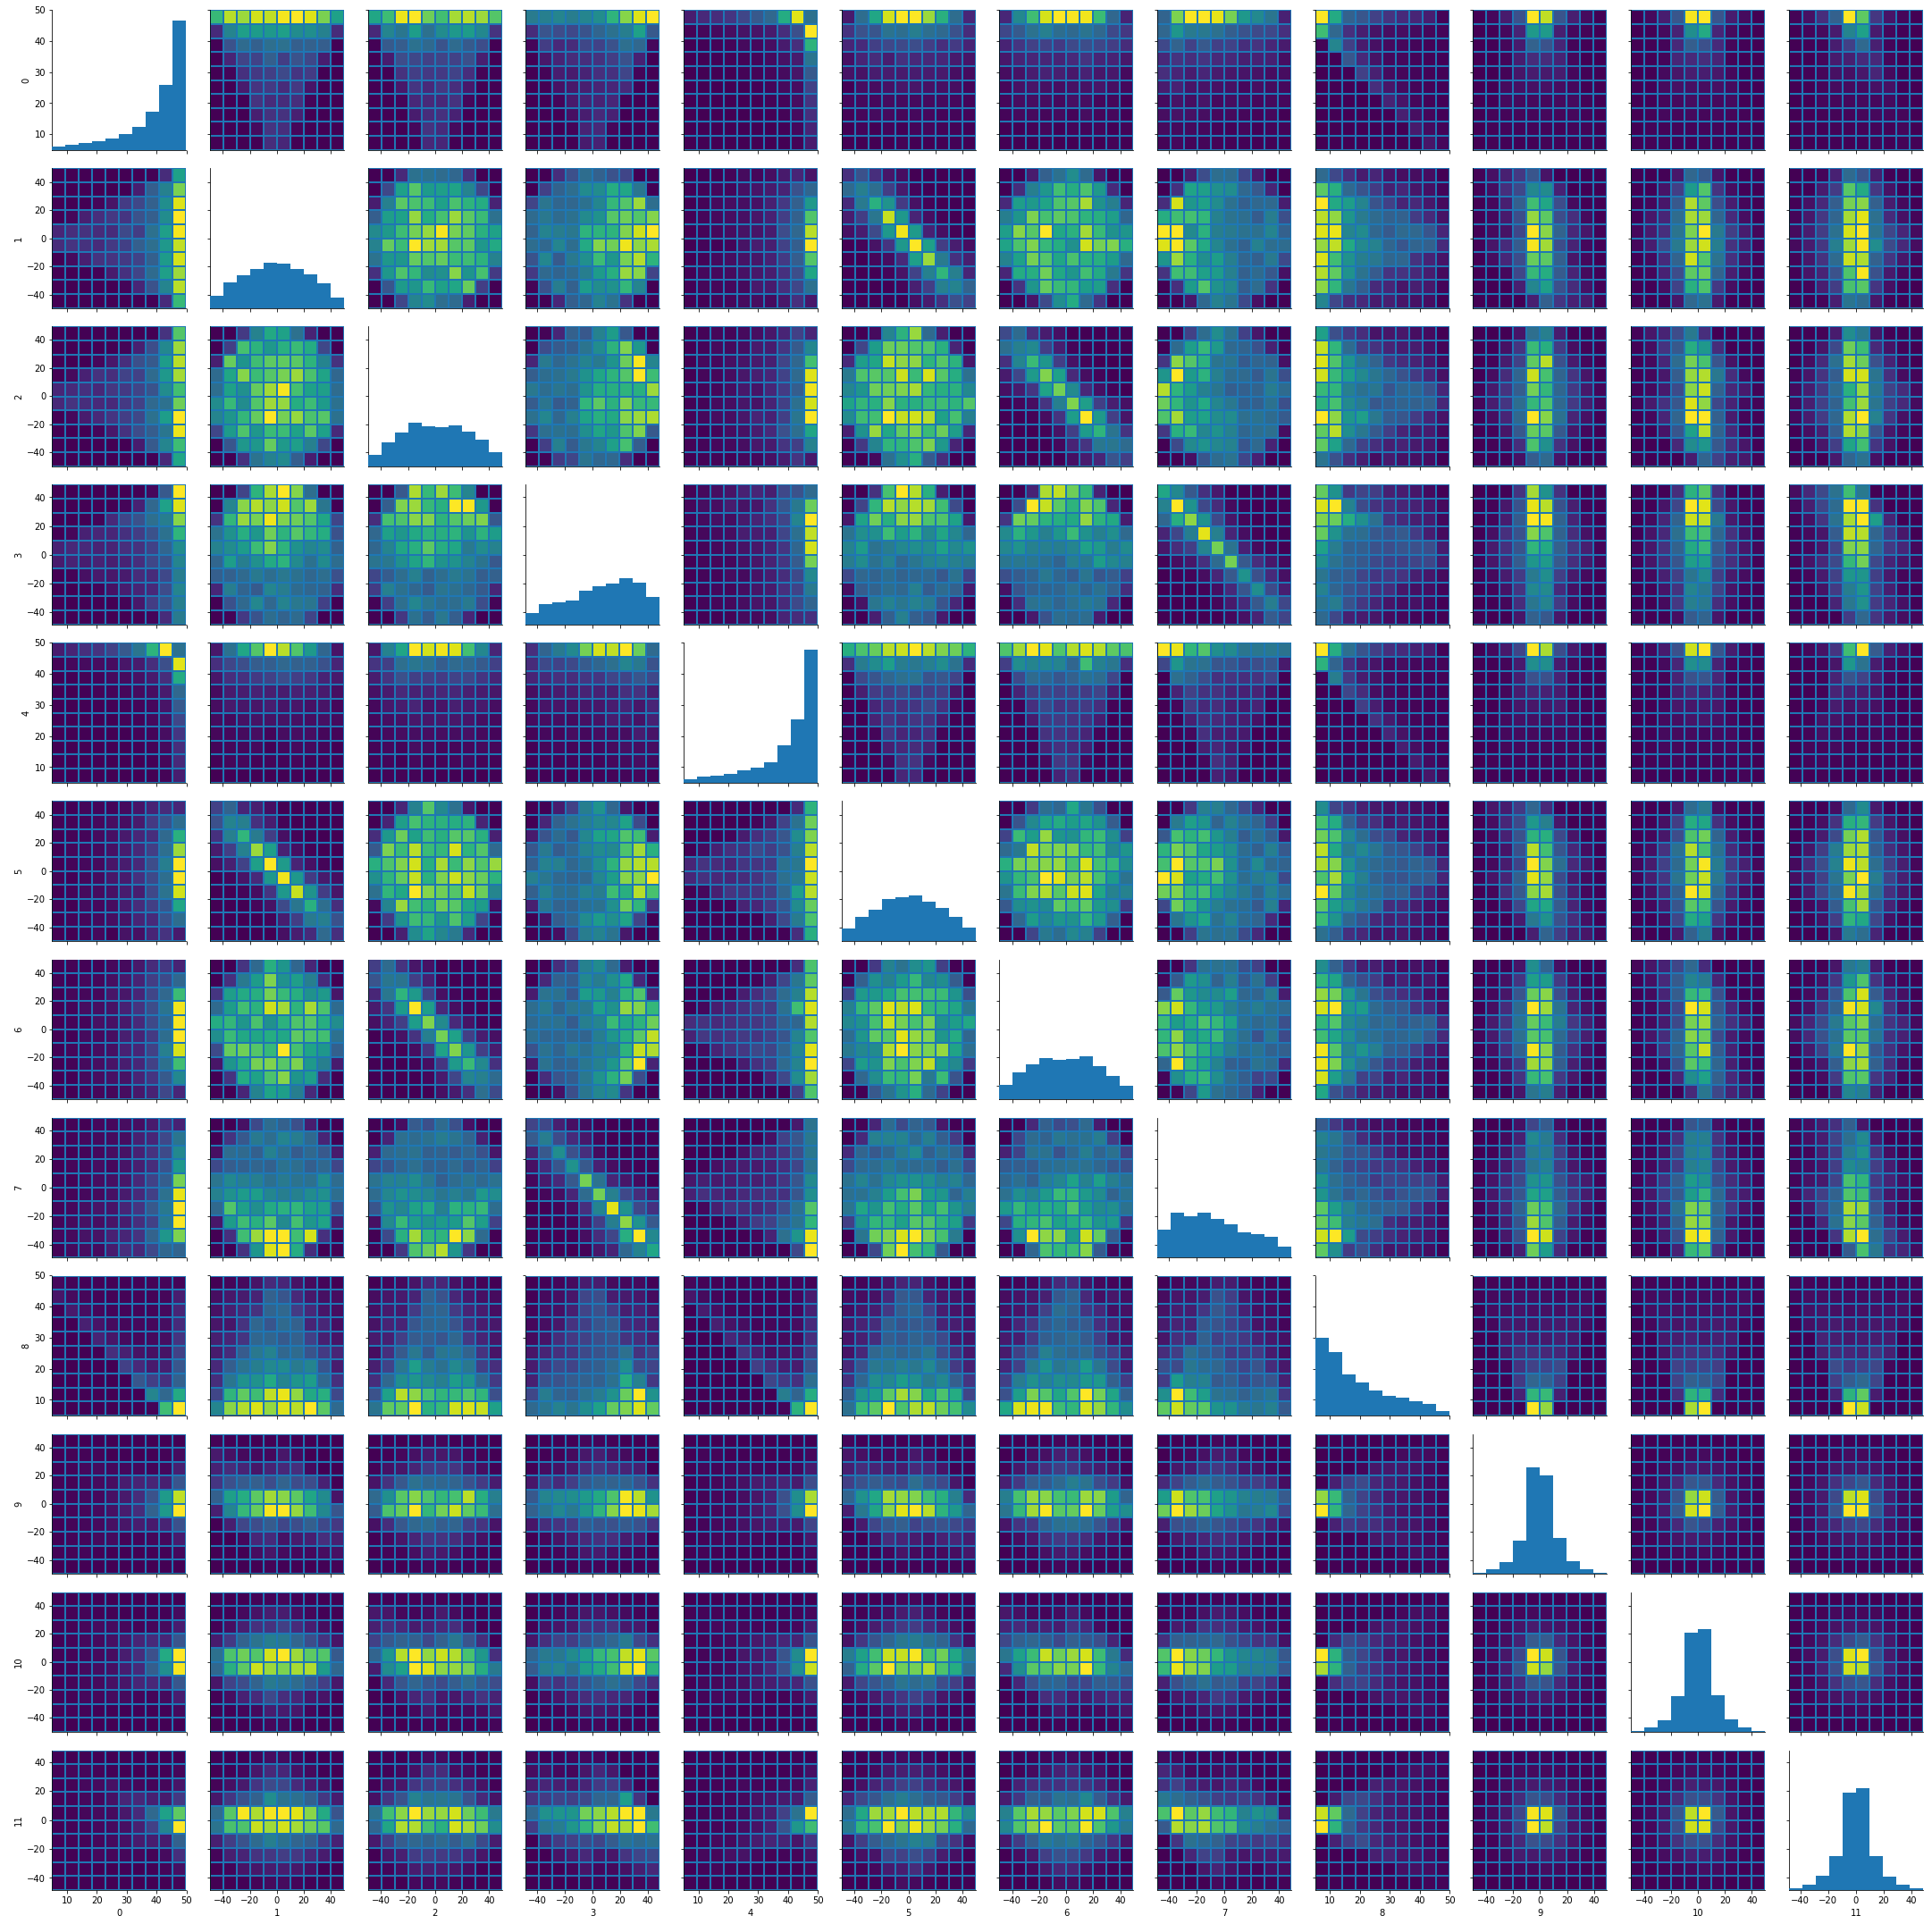

In [4]:
f = sns.PairGrid(sarge_sample_df)
f = f.map_diag(plt.hist, weights=sarge_sample.weights, bins=10)
f = f.map_offdiag(plt.hist2d, weights=sarge_sample.weights, bins=10)

In [5]:
sarge_sample_df = pd.DataFrame(rambo_mapping.map_inverse(sarge_sample.data))

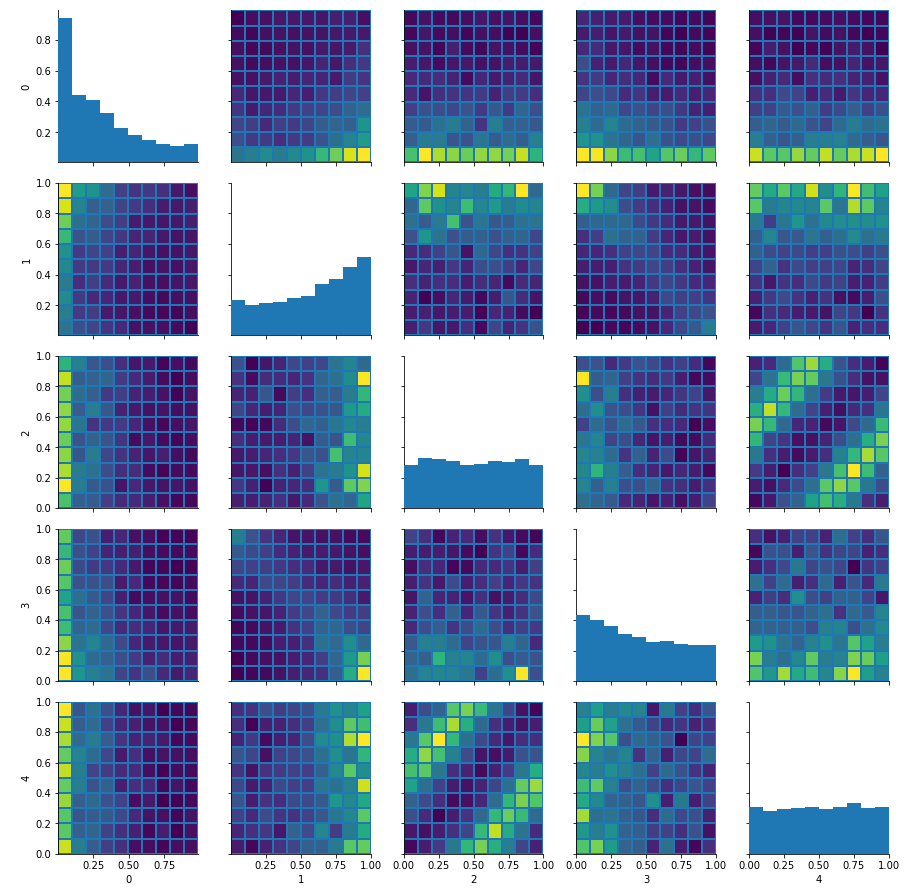

In [6]:
g = sns.PairGrid(sarge_sample_df)
g = g.map_diag(plt.hist, weights=sarge_sample.weights, bins=10)
g = g.map_offdiag(plt.hist2d, weights=sarge_sample.weights, bins=10)

In [ ]:
xvals = np.random.random((100000, 5))
fvals = mapped.pdf(xvals)

In [ ]:
xvals_df = pd.DataFrame(xvals)
zeros_df = pd.DataFrame(zeros)

In [ ]:
h = sns.PairGrid(zeros_df)
h = h.map_diag(plt.hist)
h = h.map_offdiag(plt.hist2d)

In [ ]:
nodes = 300
nlearn = 100000

xvals = np.random.random((nlearn, 5))
fvals = mapped.pdf(xvals)

# surrogate
basis = surrogate.extreme_learning.GaussianBasis(5)
#log_vals = -np.ma.log(fvals)
#xvals = xvals[~log_vals.mask]
#log_vals = log_vals[~log_vals.mask]
# train
%time params = basis.extreme_learning_train(xvals, fvals, nodes)

# surrogate
def surrogate_fn(xs):
    return basis.eval(*params, xs)[0]

# surrogate gradient
def surrogate_gradient(xs):
    return basis.eval_gradient(*params, xs)
#mapped.pot_gradient = surrogate_gradient
#mapped.pdf_gradient = surrogate_gradient

def pot_gradient(xs):
    pdf = mapped.pdf(xs)
    if pdf == 0:
        return np.full(5, np.inf)
    
    return -surrogate_gradient(xs) / pdf

mapped.pot_gradient = pot_gradient

In [ ]:
surrogate_vals = np.array([surrogate_fn(val) for val in xvals_df.values])

In [ ]:
i = sns.PairGrid(xvals_df)
i = i.map_diag(plt.hist, weights=surrogate_vals, bins=15)
i = i.map_offdiag(plt.hist2d, weights=surrogate_vals, bins=15)

In [ ]:
start = np.random.random(5)
#start = rambo_mapping.map_inverse(sarge_sample.data[-1])[0]
print('start:', start)
print('pdf:', mapped.pdf(start))
print('pot:', mapped.pot(start))
print('pot_grad:', mapped.pot_gradient(start))
sampler = StaticSphericalHMC(mapped, .005, .1, 2, 10)
%time hmc_sample = sampler.sample(15000, start)

In [ ]:
hmc_sample = Sample(data=hmc_sample.data[5000:], weights=hmc_sample.weights[5000:])
hmc_sample_df = pd.DataFrame(hmc_sample.data)

In [ ]:
k = sns.PairGrid(hmc_sample_df)
k = k.map_diag(plt.hist, bins=15, weights=hmc_sample.weights)
k = k.map_offdiag(plt.hist2d, bins=15, weights=hmc_sample.weights, cmax=.5)

In [ ]:
# Surrogate HMC without spherical augmentation
start = np.random.random(5)
print('start:', start)
print('pot:', mapped.pot(start))

sampler = HamiltonianUpdate(mapped, Gaussian(5, 1.), 30, .001)
%time hmc_sample = sampler.sample(15000, start)

In [ ]:
mapped_hmc_sample = Sample(data=rambo_mapping.map(hmc_sample.data[5000:]), weights=np.full(10000, 1/10000))
export_hepmc(100., mapped_hmc_sample, "../samples/qcd/2-3/hmc.hepmc")

In [ ]:
hmc_sample_df = pd.DataFrame(hmc_sample.data[5000:])

In [ ]:
h = sns.PairGrid(hmc_sample_df)
h = h.map_diag(plt.hist)
h = h.map_offdiag(plt.hist2d)

In [ ]:
start = np.random.random(5)
sampler = StaticSphericalHMC(mapped, 3., 3., 4, 4)
%time spherical_sample = sampler.sample(15000, start)

In [ ]:
spherical_sample_df = pd.DataFrame(spherical_sample.data)

In [ ]:
i = sns.PairGrid(spherical_sample_df)
i = i.map_diag(plt.hist, weights=spherical_sample.weights)
i = i.map_offdiag(plt.hist2d, weights=spherical_sample.weights)